# Calculate the optical properties of different aerosol populations

In this notebook, we show an example of how to calculate the optical properties of different aerosol populations. The calculations performed in this notebook are analogous to those in the *Makephase* programme of NEMESIS, which have been imported into archNEMESIS.

The type of calculations or optical properties we can calculate with this programme are based on the input *ISCAT* parameter, which can take the following values:

- **ISCAT = 1**: Mie theory following a standard gamma particle size distribution.
- **ISCAT = 2**: Mie theory following a log-normal particle size distribution.
- **ISCAT = 3**: Mie theory following an MCS modified gamma particle size distribution.
- **ISCAT = 4**: Mie theory for a single particle size.
- **ISCAT = 5**: Isotropic scattering.
- **ISCAT = 6**: Henyey-Greenstein scattering.
- **ISCAT = 7**: Dipole scattering.

Apart from the type of calculations to be performed, we need to decide the type of format in which the phase function is given back by *Makephase*, which is defined by the flag Scatter.*IMIE*. 

- If **IMIE = 0**, then the calculated phase function is fitted with a double Henyey-Greenstein function, which will be stored in the parameters Scatter.*G1*, Scatter.*G2* and Scatter.*F*.
- If **IMIE = 1**, then the phase function is stored explicitly in the class, and the phase function at other angles will be calculated by interpolation. In this case, the information of the phase function will be stored in the parameters Scatter.*THETA* and Scatter.*PHASE*.
- If **IMIE = 2**, then the phase function is fitted using a number of Legendre polynomials. The number of Legendre polynomials is given as an input with Scatter.*NLPOL* and the weights of the different polynomials is stored in the parameter Scatter.*WLPOL*.

In any case, while this is an "internal way" of storing the information within the Scatter class, the phase function at any angle and wavelength can be calculated using the function Scatter.*calc_phase*. While the phase function can be stored in these different ways in the Scatter class, note that all of the aerosol populations defined in the class need to share the same format (i.e., the same *IMIE*).

One important thing to note is that *Makephase* calculates the explicit representation of the phase function. After performing this calculation, it will perform a fitting of the phase function using either a double Henyey-Greenstein function or a combination of Legendre polynomials in case our Scatter class requires *IMIE* = 0 or 2. However, it is recommended to check the accuracy of the fitting and the representation of our explicit phase function using these approximations, as there may be cases that our phase function cannot be accurately represented by a double H-G function. 

In the following sections, we show some examples of how we can use the *Makephase* function for some different cases.

In [1]:
import archnemesis as ans
import matplotlib.pyplot as plt
import numpy as np

/home/stem/ja22256/Documents/Projects/venv_planetary_python3.11/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-07-31 17:24:19,446	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## 1. Definition of the refractive index

For most of the calculations made by *Makephase* (at least those using Mie Theory), we need to define the complex refractive index of the material the aerosols are made of. We can define the refractive index manually by modifying the parameters: Scatter.*WAVER*, Scatter.*REFIND_REAL*, Scatter.*REFIND_IM*. These parameters define the complex refractive index at different wavelengths. Note that these arrays must always be defined in wavelength units (i.e., $\mu$m) and cannot be defined in wavenumbers for now.

Alternatively, we can automatically load the refractive indices of several pre-defined materials typically found in planetary atmospheres. These refractive indices are stored in a python dictionary called aerosol_info under the Data/aerosol_data/ directory.

In [2]:
#Printing the name of the materials that are listed in the dictionary
ans.aerosol_data.print_id_names()

1 Mars dust (Wolff et al. 2006)
2 Water ice (Warren et al. 2008)
3 CO2 ice (Warren et al. 1986)
4 Sulfuric acid 75% (Palmer and Williams, 1975)


Text(0, 0.5, 'Refractive index')

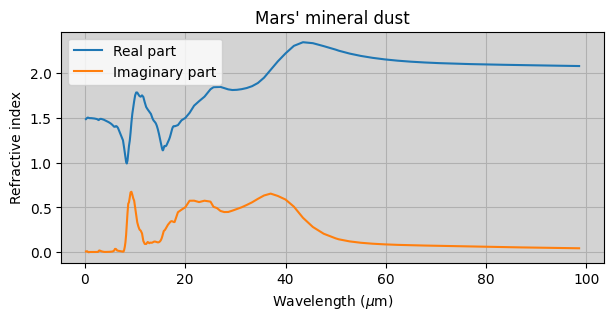

In [3]:
#Initialising the scatter class
Scatter = ans.Scatter_0()

#Reading the refractive index from the dictionary (Mars dust)
Scatter.read_refind(1)

#Making plot of the refractive index
fig,ax1 = plt.subplots(1,1,figsize=(7,3))
ax1.plot(Scatter.WAVER,Scatter.REFIND_REAL,label='Real part')
ax1.plot(Scatter.WAVER,Scatter.REFIND_IM,label='Imaginary part')
ax1.legend()
ax1.grid()
ax1.set_facecolor('lightgray')
ax1.set_title("Mars' mineral dust")
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_ylabel('Refractive index')

## 2. Calculating the optical properties for a standard gamma distribution

In this example we are going to calculate the optical properties (i.e., extinction coefficient, single scattering albedo and the phase function) for CO$_2$ ice following a standard gamma distribution. In archNEMESIS, this type of distribution is implemented as

\begin{equation}
n(r) = r^\alpha \cdot \mathrm{e}^{-r/(a\cdot b)},
\end{equation}

where $a$, $b$ and $\alpha$ are the input parameters to the function.

In the article by [Hansen and Travis (1974)](https://www.doi.org/10.1007/BF00168069), they present a form of the standard gamma distribution where $\alpha$ = $(1-3b)/b$. In that case, we have that the parameters $a$ and $b$ are directly related to the effective radius and variance of the distribution. In particular, in this case $a$ = $r_{\mathrm{eff}}$ and $b$ = $\nu_{\mathrm{eff}}$. In our example, we are going to model the particle size distribution with $r_{\mathrm{eff}}$ = 1.0 $\mu$m and $\nu_{\mathrm{eff}}$ = 0.1.

### Visualising the particle size distribution

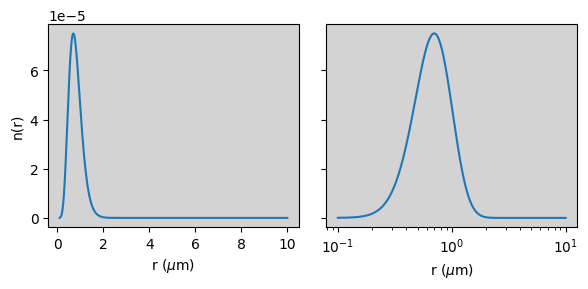

In [4]:
#Calculating standard gamma distribution
reff = 1.0 ; veff = 0.1
a = reff ; b = veff ; alpha = (1.0-3*b)/b

r = np.arange(1.0e-1,1.0e1+1.0e-3,1.0e-3)
nr = r**alpha * np.exp(-r/(a*b))

#Making summary plot
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3),sharey=True)
ax1.plot(r,nr)
ax2.plot(r,nr)
ax2.set_xscale('log')
ax1.set_xlabel('r ($\mu$m)')
ax2.set_xlabel('r ($\mu$m)')
ax1.set_ylabel('n(r)')
ax1.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')
plt.tight_layout()

### Running Makephase

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.000063103285268
Maximum integral of phase function is  1.0026559667729391
Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0000394389412832
Maximum integral of phase function is  1.0016589199140793


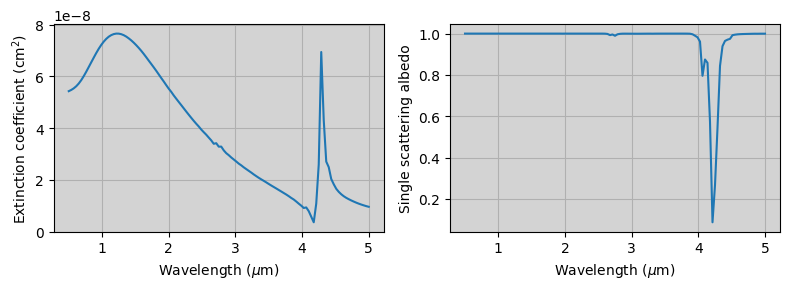

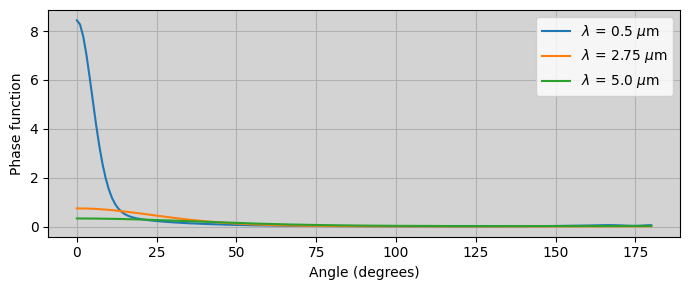

In [5]:
#Defining the general inputs for our class
###############################################################################################

#Initialising the scatter class
Scatter = ans.Scatter_0()

#Defining the characteristics of the class
Scatter.ISPACE = 1   #Units of the calculations (0 - Wavenumber in cm-1 ; 1 - Wavelength in um)
Scatter.IMIE = 1     #Phase function defined explicitly

NDUST = 1      #Number of aerosol populations that we want to include in our atmosphere
NWAVE = 121    #Number of spectral points
NTHETA = 181   #Number of angles for defining the phase function (from 0 to 180)
wavel = np.linspace(0.5,5.,NWAVE)
theta = np.linspace(0.,180.,NTHETA)

#Now we initialise the arrays that will be filled with the calculations
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Defining the inputs for our calculations of this particle aerosol distribution
################################################################################################

#Reading the refractive index from the dictionary (CO2 ice)
Scatter.read_refind(3)

#Defining the inputs for our standard gamma particle size distribution
iscat = 1  #Standard gamma distribution
a = 1.0 ; b = 0.1 ; alpha = (1-3.*b)/b
pars = np.array([a,b,alpha]) 

idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

#Making a summary plot
#################################################################################################

#Plotting the extinction coefficient and single scattering albedo
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3))

ax1.plot(Scatter.WAVE,Scatter.KEXT[:,idust])
ax1.grid()
ax1.set_ylabel('Extinction coefficient (cm$^2$)')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_facecolor('lightgray')

ax2.plot(Scatter.WAVE,Scatter.SGLALB[:,idust])
ax2.grid()
ax2.set_ylabel('Single scattering albedo')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_facecolor('lightgray')
plt.tight_layout()

#Plotting the phase function for three wavelengths
fig,(ax1) = plt.subplots(1,1,figsize=(7,3))

iwave = 0
ax1.plot(Scatter.THETA,Scatter.PHASE[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = int(Scatter.NWAVE/2)
ax1.plot(Scatter.THETA,Scatter.PHASE[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = Scatter.NWAVE - 1
ax1.plot(Scatter.THETA,Scatter.PHASE[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')

ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Phase function')
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.legend()
plt.tight_layout()

Scatter.check_phase_norm()

#Calculating the phase function with IMIE = 1
######################################################################################
phase_explicit = Scatter.calc_phase(Scatter.THETA,Scatter.WAVE)


### Checking the accuracy of the choice of IMIE

As mentioned in the introduction, what *Makephase* calculates is the phase function at a given set of specified angles. When we select *IMIE* = 0 or 2 in the Scatter class, the program will fit the calculated phase function with a double Henyey-Greenstein function or a combination of Legendre polynomials. However, it is recommended to check the validity of these approximations since we may find cases in which our phase function cannot be accurately reproduced by a double Henyey-Greenstein function for example. 

In this section, we are going to check how the phase functions computed with the three choice of *IMIE* compare.

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.000063103285268
Maximum integral of phase function is  1.0026559667729391
Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.000063103285268
Maximum integral of phase function is  1.0026559667729391


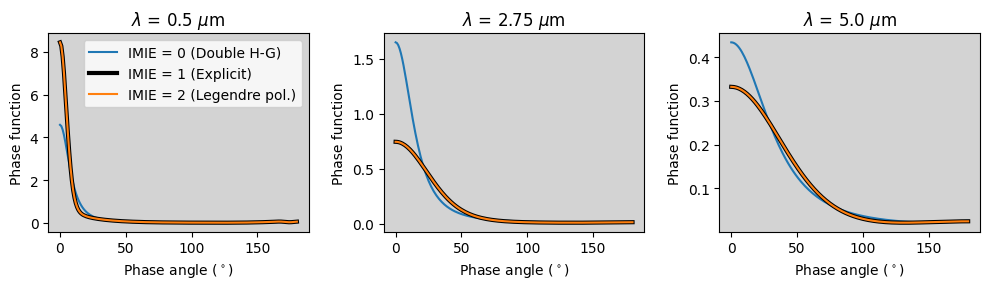

In [6]:
#Calculating the phase function with IMIE = 0 (double H-G function)
######################################################################################

Scatter.IMIE = 0

#Initialising arrays again
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Calling Makephase
idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

phase_hg = Scatter.calc_phase(Scatter.THETA,Scatter.WAVE)


#Calculating the phase function with IMIE = 2 (Legendre polynomials)
######################################################################################

Scatter.IMIE = 2

NLPOL = 100   #100 Legendre polynomials

#Initialising arrays again
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA,NLPOL)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Calling Makephase
idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

phase_lp = Scatter.calc_phase(Scatter.THETA,Scatter.WAVE)




#Making summary plot
########################################################################################

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3))

iwave = 0
ax1.plot(Scatter.THETA,phase_hg[iwave,:,idust],label='IMIE = 0 (Double H-G)')
ax1.plot(Scatter.THETA,phase_explicit[iwave,:,idust],label='IMIE = 1 (Explicit)',c='black',linewidth=3.)
ax1.plot(Scatter.THETA,phase_lp[iwave,:,idust],label='IMIE = 2 (Legendre pol.)')
ax1.set_title('$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
ax1.set_facecolor('lightgray')

iwave = int(Scatter.NWAVE/2)
ax2.plot(Scatter.THETA,phase_hg[iwave,:,idust],label='IMIE = 0')
ax2.plot(Scatter.THETA,phase_explicit[iwave,:,idust],label='IMIE = 1',c='black',linewidth=3.)
ax2.plot(Scatter.THETA,phase_lp[iwave,:,idust],label='IMIE = 2')
ax2.set_title('$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
ax2.set_facecolor('lightgray')

iwave = Scatter.NWAVE - 1
ax3.plot(Scatter.THETA,phase_hg[iwave,:,idust],label='IMIE = 0')
ax3.plot(Scatter.THETA,phase_explicit[iwave,:,idust],label='IMIE = 1',c='black',linewidth=3.)
ax3.plot(Scatter.THETA,phase_lp[iwave,:,idust],label='IMIE = 2')
ax3.set_title('$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
ax3.set_facecolor('lightgray')

ax1.legend()

ax1.set_xlabel('Phase angle ($^\circ$)')
ax2.set_xlabel('Phase angle ($^\circ$)')
ax3.set_xlabel('Phase angle ($^\circ$)')

ax1.set_ylabel('Phase function')
ax2.set_ylabel('Phase function')
ax3.set_ylabel('Phase function')

plt.tight_layout()

## 3. Calculating the optical properties for a log-normal distribution

In this case, we use the *Makephase* programme to calculate the optical properties for Mars mineral dust following a log-normal distribution with $r_{\mathrm{eff}}$ = 1.5 and $\nu_{\mathrm{eff}}$ = 0.2. In archNEMESIS, the log-normal distribution is defined following

\begin{equation}
n(r) = \dfrac{1}{\sigma_g r \sqrt{2\pi}} \exp \left( \dfrac{-(\ln{r} - \ln{r_g})^2}{2 \sigma_g^2} \right),
\end{equation}

where $r_g$ is the median of the distribution and $\sigma_g$ is the standard deviation. The mean of the distribution is related to the median by $\mu$ = $\ln{r_g}$, or similarly, $r_g$ = e$^\mu$. Simiarly, we can relate these parameters to the effective radius and variance following the description in  [Hansen and Travis (1974)](https://www.doi.org/10.1007/BF00168069) given by

\begin{equation}
r_g = r_{\mathrm{eff}}/(1+\nu_{\mathrm{eff}})^{5/2},
\end{equation}

\begin{equation}
\sigma_g^2 = \ln{(1+\nu_{\mathrm{eff}})}.
\end{equation}

In this case, we are going to set *IMIE* to zero, so that we store the parameters defining the phase function as a double Henyey-Greenstein function.

### Visualising the distribution

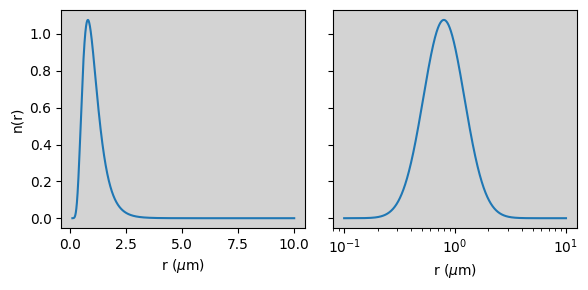

In [7]:
#Calculating modified gamma distribution
reff = 1.5 ; veff = 0.2
r_g = reff/(1.+veff)**(5./2.)
sigma_g = np.sqrt(np.log(1.0+veff))

r = np.arange(1.0e-1,1.0e1+1.0e-3,1.0e-3)
nr = 1./(sigma_g*r*np.sqrt(2.*np.pi)) * np.exp(-(np.log(r)-np.log(r_g))**2. / (2.*sigma_g**2.) )

#Making summary plot
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3),sharey=True)
ax1.plot(r,nr)
ax2.plot(r,nr)
ax2.set_xscale('log')
ax1.set_xlabel('r ($\mu$m)')
ax2.set_xlabel('r ($\mu$m)')
ax1.set_ylabel('n(r)')
ax1.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')
plt.tight_layout()

### Running Makephase

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.000179599072522
Maximum integral of phase function is  1.0078703107462472
Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0000824151699763
Maximum integral of phase function is  1.000688326241077


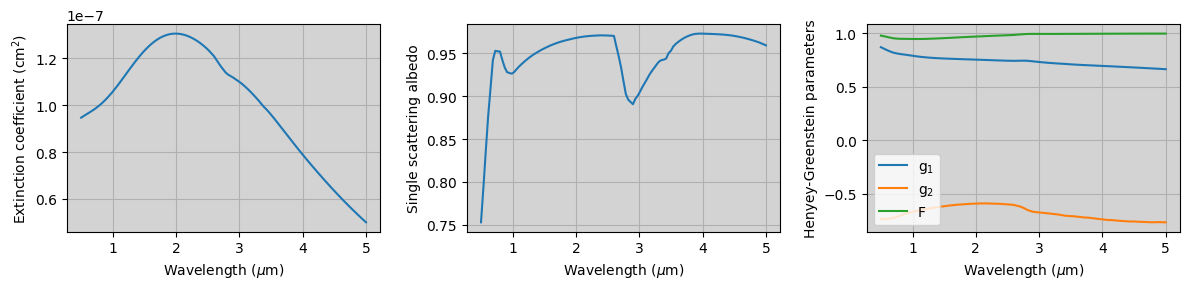

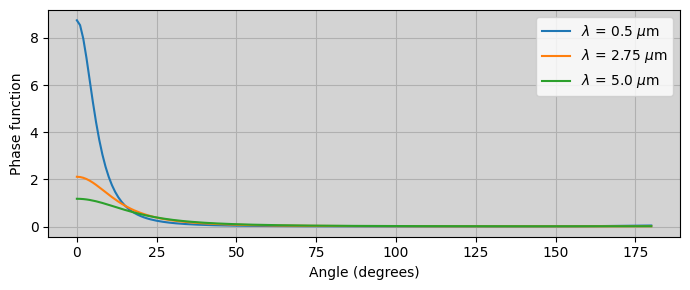

In [8]:
#Defining the general inputs for our class
###############################################################################################

#Initialising the scatter class
Scatter = ans.Scatter_0()

#Defining the characteristics of the class
Scatter.ISPACE = 1   #Units of the calculations (0 - Wavenumber in cm-1 ; 1 - Wavelength in um)
Scatter.IMIE = 0     #Phase function defined using a double Henyey Greenstein function

NDUST = 1      #Number of aerosol populations that we want to include in our atmosphere
NWAVE = 121    #Number of spectral points
NTHETA = 181   #Number of angles for defining the phase function (from 0 to 180)
wavel = np.linspace(0.5,5.,NWAVE)
theta = np.linspace(0.,180.,NTHETA)

#Now we initialise the arrays that will be filled with the calculations
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Defining the inputs for our calculations of this particle aerosol distribution
################################################################################################

#Reading the refractive index from the dictionary (Mars mineral dust)
Scatter.read_refind(1)

#Defining the inputs for our standard gamma particle size distribution
iscat = 2  #Log-normal distribution
reff = 1.5 ; veff = 0.2
r_g = reff/(1.+veff)**(5./2.)
sigma_g = np.sqrt(np.log(1.0+veff))
pars = np.array([r_g,sigma_g]) 

idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

#Making a summary plot
#################################################################################################

#Plotting the extinction coefficient and single scattering albedo and the double HG parameters
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))

ax1.plot(Scatter.WAVE,Scatter.KEXT[:,idust])
ax1.grid()
ax1.set_ylabel('Extinction coefficient (cm$^2$)')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_facecolor('lightgray')

ax2.plot(Scatter.WAVE,Scatter.SGLALB[:,idust])
ax2.grid()
ax2.set_ylabel('Single scattering albedo')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_facecolor('lightgray')


ax3.plot(Scatter.WAVE,Scatter.G1[:,idust],label='g$_1$')
ax3.plot(Scatter.WAVE,Scatter.G2[:,idust],label='g$_2$')
ax3.plot(Scatter.WAVE,Scatter.F[:,idust],label='F')
ax3.grid()
ax3.legend(loc='lower left')
ax3.set_ylabel('Henyey-Greenstein parameters')
ax3.set_xlabel('Wavelength ($\mu$m)')
ax3.set_facecolor('lightgray')

plt.tight_layout()

#Calculating the actual phase function from our double HG parameterisation
##################################################################################################

theta = np.linspace(0.,180.,181)
phase_hg = Scatter.calc_phase(theta,Scatter.WAVE)

#Plotting the phase function for three wavelengths
fig,(ax1) = plt.subplots(1,1,figsize=(7,3))

iwave = 0
ax1.plot(theta,phase_hg[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = int(Scatter.NWAVE/2)
ax1.plot(theta,phase_hg[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = Scatter.NWAVE - 1
ax1.plot(theta,phase_hg[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')

ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Phase function')
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.legend()
plt.tight_layout()

Scatter.check_phase_norm()


### Checking the accuracy of the choice of IMIE

As mentioned in the introduction, what *Makephase* calculates is the phase function at a given set of specified angles. When we select *IMIE* = 0 or 2 in the Scatter class, the program will fit the calculated phase function with a double Henyey-Greenstein function or a combination of Legendre polynomials. However, it is recommended to check the validity of these approximations since we may find cases in which our phase function cannot be accurately reproduced by a double Henyey-Greenstein function for example. 

In this section, we are going to check how the phase functions computed with the three choice of *IMIE* compare.

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.000179599072522
Maximum integral of phase function is  1.0078703107462472
Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.000179599072522
Maximum integral of phase function is  1.0078703107462472


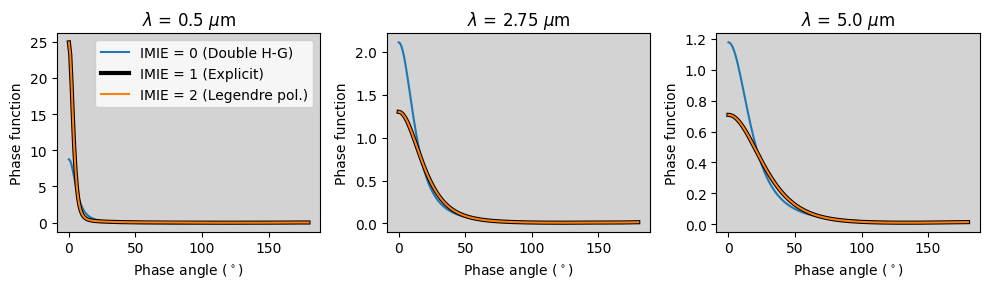

In [9]:
#Calculating the phase function with IMIE = 1 (explicit)
######################################################################################

Scatter.IMIE = 1

#Initialising arrays again
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Calling Makephase
idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

phase_explicit = Scatter.calc_phase(Scatter.THETA,Scatter.WAVE)


#Calculating the phase function with IMIE = 2 (Legendre polynomials)
######################################################################################

Scatter.IMIE = 2

NLPOL = 100   #100 Legendre polynomials

#Initialising arrays again
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA,NLPOL)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Calling Makephase
idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

phase_lp = Scatter.calc_phase(Scatter.THETA,Scatter.WAVE)




#Making summary plot
########################################################################################

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3))

iwave = 0
ax1.plot(Scatter.THETA,phase_hg[iwave,:,idust],label='IMIE = 0 (Double H-G)')
ax1.plot(Scatter.THETA,phase_explicit[iwave,:,idust],label='IMIE = 1 (Explicit)',c='black',linewidth=3.)
ax1.plot(Scatter.THETA,phase_lp[iwave,:,idust],label='IMIE = 2 (Legendre pol.)')
ax1.set_title('$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
ax1.set_facecolor('lightgray')

iwave = int(Scatter.NWAVE/2)
ax2.plot(Scatter.THETA,phase_hg[iwave,:,idust],label='IMIE = 0')
ax2.plot(Scatter.THETA,phase_explicit[iwave,:,idust],label='IMIE = 1',c='black',linewidth=3.)
ax2.plot(Scatter.THETA,phase_lp[iwave,:,idust],label='IMIE = 2')
ax2.set_title('$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
ax2.set_facecolor('lightgray')

iwave = Scatter.NWAVE - 1
ax3.plot(Scatter.THETA,phase_hg[iwave,:,idust],label='IMIE = 0')
ax3.plot(Scatter.THETA,phase_explicit[iwave,:,idust],label='IMIE = 1',c='black',linewidth=3.)
ax3.plot(Scatter.THETA,phase_lp[iwave,:,idust],label='IMIE = 2')
ax3.set_title('$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
ax3.set_facecolor('lightgray')

ax1.legend()

ax1.set_xlabel('Phase angle ($^\circ$)')
ax2.set_xlabel('Phase angle ($^\circ$)')
ax3.set_xlabel('Phase angle ($^\circ$)')

ax1.set_ylabel('Phase function')
ax2.set_ylabel('Phase function')
ax3.set_ylabel('Phase function')

plt.tight_layout()


## 4. Calculating the optical properties for a Modified gamma distribution

The modified gamma distribution is defined in archNEMESIS as 

\begin{equation}
n(r) = r^a \cdot \mathrm{e}^{-b\cdot r^c},
\end{equation}

where $a$, $b$ and $c$ are the input parameters in our distribution. For our example, we are going to choose values of $a$ = 2, $b$ = 8 $\times$ 10$^{-3}$ and $c$ = 6. The wavelength range of the calculation is going to be from 5 to 10 $\mu$m, and we are going to use the refractive index of a solution of sulfuric acid and water (i.e., refractive index #4 in the dictionary). We are going to select *IMIE* = 2 so that the output of *Makephase* into the Scatter class is given as the weights of the 100 Legendre polynomials we want to use to fit the phase function.

### Visualising the particle size distribution



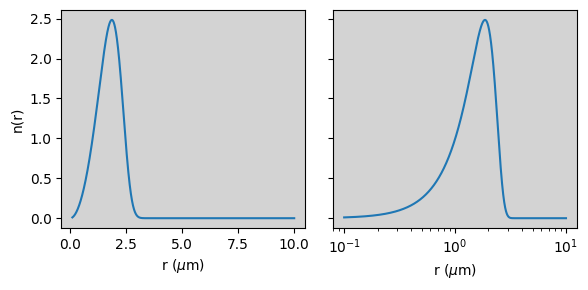

In [10]:
#Calculating modified gamma distribution
a = 2. ; b = 8.e-3 ; c = 6. 
r = np.arange(1.0e-1,1.0e1+1.0e-3,1.0e-3)
nr = r**a * np.exp(-b*r**c)

#Making summary plot
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(6,3),sharey=True)
ax1.plot(r,nr)
ax2.plot(r,nr)
ax2.set_xscale('log')
ax1.set_xlabel('r ($\mu$m)')
ax2.set_xlabel('r ($\mu$m)')
ax1.set_ylabel('n(r)')
ax1.set_facecolor('lightgray')
ax2.set_facecolor('lightgray')
plt.tight_layout()


### Running Makephase

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0000450198632251
Maximum integral of phase function is  1.0001966612381192
Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.000011255322207
Maximum integral of phase function is  1.0000491675803809


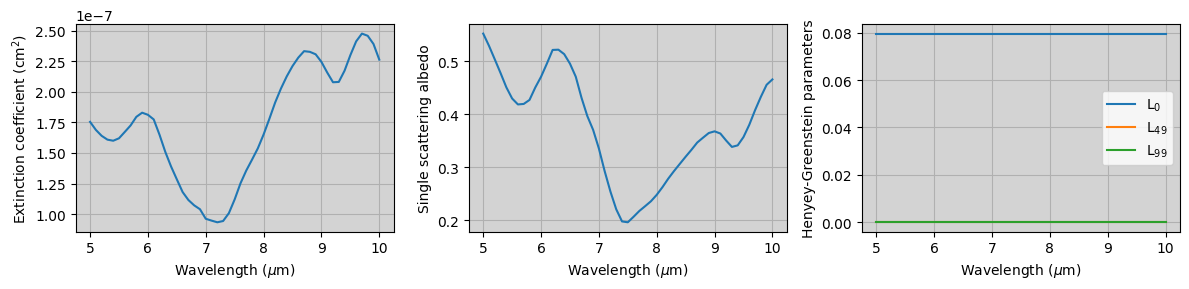

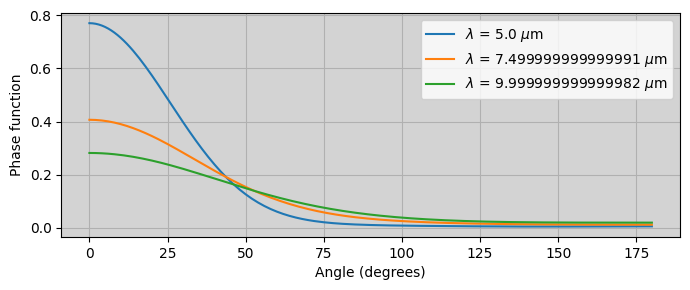

In [11]:
#Defining the general inputs for our class
###############################################################################################

#Initialising the scatter class
Scatter = ans.Scatter_0()

#Defining the characteristics of the class
Scatter.ISPACE = 1   #Units of the calculations (0 - Wavenumber in cm-1 ; 1 - Wavelength in um)
Scatter.IMIE = 2     #Phase function defined using a combination of Legendre polynomials

NDUST = 1      #Number of aerosol populations that we want to include in our atmosphere
NLPOL = 100    #Number of Legendre polynomials to describe the phase function

wavel = np.arange(5.,10.+0.1,0.1)
NWAVE = len(wavel)    #Number of spectral points

NTHETA = 181   #Number of angles for defining the phase function (from 0 to 180)
theta = np.linspace(0.,180.,NTHETA) #Number of phase angles

#Now we initialise the arrays that will be filled with the calculations
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA,NLPOL=NLPOL)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Defining the inputs for our calculations of this particle aerosol distribution
################################################################################################

#Reading the refractive index from the dictionary (Mars mineral dust)
Scatter.read_refind(4)

#Defining the inputs for our standard gamma particle size distribution
iscat = 3  #Modified gamma distribution
a = 2. ; b = 8.e-3 ; c = 6. 
pars = np.array([a,b,c]) 

idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

#Making a summary plot
#################################################################################################

#Plotting the extinction coefficient and single scattering albedo and the double HG parameters
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))

ax1.plot(Scatter.WAVE,Scatter.KEXT[:,idust])
ax1.grid()
ax1.set_ylabel('Extinction coefficient (cm$^2$)')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_facecolor('lightgray')

ax2.plot(Scatter.WAVE,Scatter.SGLALB[:,idust])
ax2.grid()
ax2.set_ylabel('Single scattering albedo')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_facecolor('lightgray')


ax3.plot(Scatter.WAVE,Scatter.WLPOL[:,0,idust],label='L$_{0}$')
ax3.plot(Scatter.WAVE,Scatter.WLPOL[:,49,idust],label='L$_{49}$')
ax3.plot(Scatter.WAVE,Scatter.WLPOL[:,99,idust],label='L$_{99}$')
ax3.grid()
ax3.legend()
ax3.set_ylabel('Henyey-Greenstein parameters')
ax3.set_xlabel('Wavelength ($\mu$m)')
ax3.set_facecolor('lightgray')

plt.tight_layout()

#Calculating the actual phase function from our double HG parameterisation
##################################################################################################

theta = np.linspace(0.,180.,181)
phase = Scatter.calc_phase(theta,Scatter.WAVE)

#Plotting the phase function for three wavelengths
fig,(ax1) = plt.subplots(1,1,figsize=(7,3))

iwave = 0
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = int(Scatter.NWAVE/2)
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = Scatter.NWAVE - 1
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')

ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Phase function')
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.legend()
plt.tight_layout()

Scatter.check_phase_norm()


## 5. Calculating the optical properties for a single particle size

With Makephase, we can also calculate the optical properties for a single particle size using the Mie formalism. In this example, we are going to model the optical properties of spherical particles with $r$ = 1.5 $\mu$m assuming a refractive index given by the Mars' dust particles (i.e. refractive index #1 in the dictionary).

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0000798739761978
Maximum integral of phase function is  1.0070108912104245
Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0000499204880666
Maximum integral of phase function is  1.0043776123659964


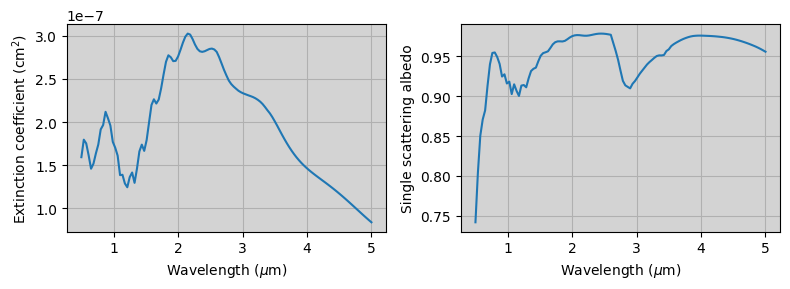

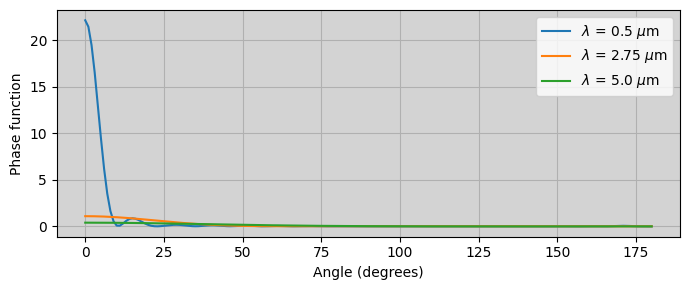

In [12]:
#Defining the general inputs for our class
###############################################################################################

#Initialising the scatter class
Scatter = ans.Scatter_0()

#Defining the characteristics of the class
Scatter.ISPACE = 1   #Units of the calculations (0 - Wavenumber in cm-1 ; 1 - Wavelength in um)
Scatter.IMIE = 1     #Phase function defined explicitly

NDUST = 1      #Number of aerosol populations that we want to include in our atmosphere
NWAVE = 121    #Number of spectral points
NTHETA = 181   #Number of angles for defining the phase function (from 0 to 180)
wavel = np.linspace(0.5,5.,NWAVE)
theta = np.linspace(0.,180.,NTHETA)

#Now we initialise the arrays that will be filled with the calculations
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA,NLPOL=NLPOL)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Defining the inputs for our calculations of this particle aerosol distribution
################################################################################################

#Reading the refractive index from the dictionary (Solution of sulfuric acid and water)
Scatter.read_refind(1)

#Defining the inputs for our standard gamma particle size distribution
iscat = 4  #Modified gamma distribution
r0 = 1.5
pars = np.array([r0]) 

idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

#Making a summary plot
#################################################################################################

#Plotting the extinction coefficient and single scattering albedo and the double HG parameters
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(8,3))

ax1.plot(Scatter.WAVE,Scatter.KEXT[:,idust])
ax1.grid()
ax1.set_ylabel('Extinction coefficient (cm$^2$)')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_facecolor('lightgray')

ax2.plot(Scatter.WAVE,Scatter.SGLALB[:,idust])
ax2.grid()
ax2.set_ylabel('Single scattering albedo')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_facecolor('lightgray')


plt.tight_layout()

#Calculating the actual phase function from our double HG parameterisation
##################################################################################################

theta = np.linspace(0.,180.,181)
phase = Scatter.calc_phase(theta,Scatter.WAVE)

#Plotting the phase function for three wavelengths
fig,(ax1) = plt.subplots(1,1,figsize=(7,3))

iwave = 0
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = int(Scatter.NWAVE/2)
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = Scatter.NWAVE - 1
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')

ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Phase function')
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.legend()
plt.tight_layout()

Scatter.check_phase_norm()


## 6. Calculating an isotropic scattering phase function

Another case that we may want to model is the case of isotropic scattering. In this case, light is scattered with equal probability in all directions, so essentially the phase function if equal at all phase angles. Note that in this *ISCAT* case we are not performing any calculations involving Mie Theory, we are just defining the phase function of the particles. Therefore, while this mode will change the parameters in the Scatter class defining the phase function (i.e., either *G1*, *G2*, and *F* if *IMIE* = 0, or *PHASE* if *IMIE* = 1, etc.), it will not change the other parameters defining the optical properties (i.e., *KEXT*, *SGLALB*, etc.). 

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0
Maximum integral of phase function is  1.0
Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0
Maximum integral of phase function is  1.0


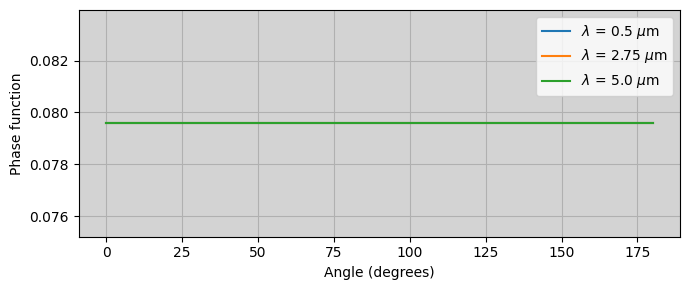

In [14]:
#Defining the general inputs for our class
###############################################################################################

#Initialising the scatter class
Scatter = ans.Scatter_0()

#Defining the characteristics of the class
Scatter.ISPACE = 1   #Units of the calculations (0 - Wavenumber in cm-1 ; 1 - Wavelength in um)
Scatter.IMIE = 1     #Phase function defined explicitly

NDUST = 1      #Number of aerosol populations that we want to include in our atmosphere
NWAVE = 121    #Number of spectral points
NTHETA = 181   #Number of angles for defining the phase function (from 0 to 180)
wavel = np.linspace(0.5,5.,NWAVE)
theta = np.linspace(0.,180.,NTHETA)

#Now we initialise the arrays that will be filled with the calculations
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Defining the inputs for our calculations of this particle aerosol distribution
################################################################################################

#Defining the inputs for our standard gamma particle size distribution
iscat = 5  #Isotropic scattering phase function
pars = np.array([]) 

idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

#Calculating the actual phase function, although since it is defined explicitly we could call it directly from PHASE
######################################################################################################################

theta = np.linspace(0.,180.,181)
phase = Scatter.calc_phase(theta,Scatter.WAVE)

#Plotting the phase function for three wavelengths
fig,(ax1) = plt.subplots(1,1,figsize=(7,3))

iwave = 0
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = int(Scatter.NWAVE/2)
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = Scatter.NWAVE - 1
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')

ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Phase function')
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.legend()
plt.tight_layout()

Scatter.check_phase_norm()


### 7. Calculating a double Henyey-Greenstein phase function

The *Makephase* function also allows us to define the phase function using a double H-G parameterisation. The double Henyey-Greenstein phase function is defined as 

\begin{equation}
P(\theta) = f \cdot P_{HG}(g_1,\theta) + (1-f) \cdot P_{HG}(g_2,\theta),
\end{equation}

\begin{equation}
P_{HG}(g,\theta) = \dfrac{1}{4\pi} \dfrac{1-g^2}{(1 - 2g\cos{\theta} + g^2)^{3/2}},
\end{equation}

where $g_1$ and $g_2$ represent the parameters for the two Henyey-Greenstein functions (negative values for backward scattering) and $f$ is the relative weight of the two functions.

In practice, we can define it directly just setting *IMIE* = 0 by changing the parameters *F*, *G1* and *G2* in the Scatter class. However, we can also use this in *Makephase* to test whether the fit of the fit of the double H-G phase that happens internally in *Makephase* is accurate or not (i.e., we should be getting the same values from *Makephase* as the ones we were defining in the inputs). 

Similar to the previous case, we are not using Mie Theory, so we are just defining the phase function of the particles. Therefore, while this mode will change the parameters in the Scatter class defining the phase function (i.e., either *G1*, *G2*, and *F* if *IMIE* = 0, or *PHASE* if *IMIE* = 1, etc.), it will not change the other parameters defining the optical properties (i.e., *KEXT*, *SGLALB*, etc.). 

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0002291774747776
Maximum integral of phase function is  1.0002291774747776
The correct input values to Makephase are : F =  0.5 G1 =  0.7 G2 =  -0.3
The output values from the double H-G fit in Makephase are :  F =  0.49999999999999994 G1 =  0.6999999999999998 G2 =  -0.3


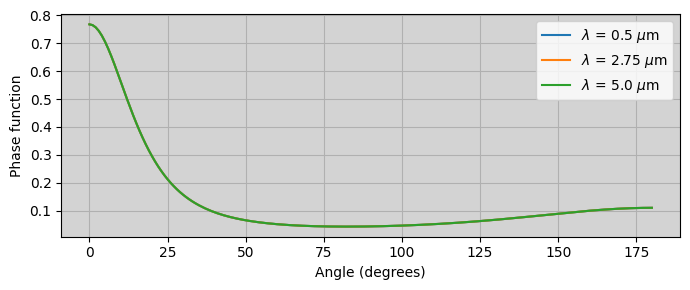

In [18]:
#Defining the general inputs for our class
###############################################################################################

#Initialising the scatter class
Scatter = ans.Scatter_0()

#Defining the characteristics of the class
Scatter.ISPACE = 1   #Units of the calculations (0 - Wavenumber in cm-1 ; 1 - Wavelength in um)
Scatter.IMIE = 0     #Phase function defined explicitly

NDUST = 1      #Number of aerosol populations that we want to include in our atmosphere
NWAVE = 121    #Number of spectral points
NTHETA = 181   #Number of angles for defining the phase function (from 0 to 180)
wavel = np.linspace(0.5,5.,NWAVE)
theta = np.linspace(0.,180.,NTHETA)

#Now we initialise the arrays that will be filled with the calculations
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Defining the inputs for our calculations of this particle aerosol distribution
################################################################################################

#Defining the inputs for our standard gamma particle size distribution
iscat = 6  #Double Henyey-Greenstein phase function
f = 0.5 ; g1 = 0.7 ; g2 = -0.3
pars = np.array([f,g1,g2]) 

idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

#Calculating the actual phase function, although since it is defined explicitly we could call it directly from PHASE
######################################################################################################################

theta = np.linspace(0.,180.,181)
phase = Scatter.calc_phase(theta,Scatter.WAVE)



#Plotting the phase function for three wavelengths
fig,(ax1) = plt.subplots(1,1,figsize=(7,3))

iwave = 0
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = int(Scatter.NWAVE/2)
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = Scatter.NWAVE - 1
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')

ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Phase function')
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.legend()
plt.tight_layout()

print('The correct input values to Makephase are : F = ',f,'G1 = ',g1,'G2 = ',g2)
print('The output values from the double H-G fit in Makephase are :  F = ',Scatter.F[0,idust],'G1 = ',Scatter.G1[0,idust],'G2 = ',Scatter.G2[0,idust])



## 8. Calculating the optical properties for dipole scattering

In archNEMESIS we can also estimate the optical properties for the aerosols following dipole scattering. This type of scattering may be used when the diameter of the scattering dielectric spheres is much lower than the wavelength of the light. For such an object, the incoming wave is effectively a spatially constant, but time-oscillating, electric field, and assuming the sphere's electric response is much faster than the wave oscillation time, we can use the electrostatic result derived long ago, that the incoming field will induce a dipole.

In this example, we are going to test this type of scattering calculations using the particles with r$_0$ = 0.01 $\mu$m. 

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0000253838183915
Maximum integral of phase function is  1.0000253838183915
0.30590441194309226 -0.30599508288984323
Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0000070952242148
Maximum integral of phase function is  1.0000070952242148


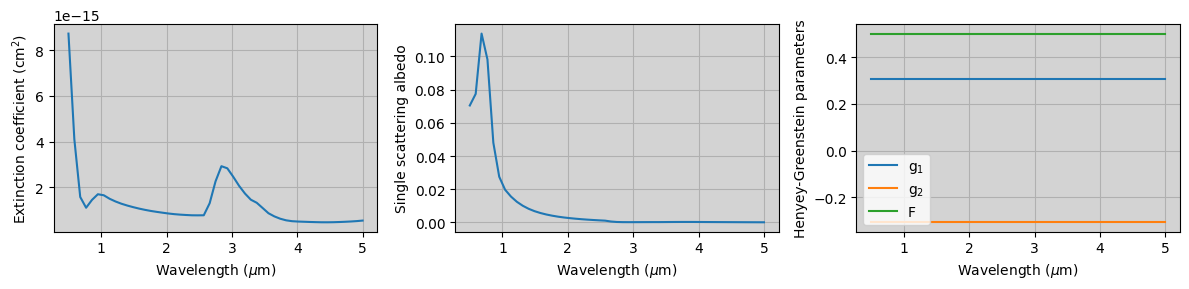

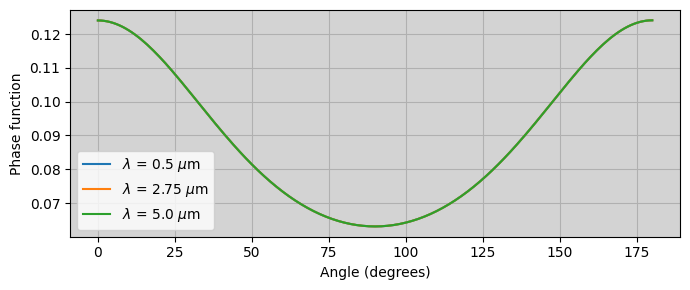

In [19]:
#Defining the general inputs for our class
###############################################################################################

#Initialising the scatter class
Scatter = ans.Scatter_0()

#Defining the characteristics of the class
Scatter.ISPACE = 1   #Units of the calculations (0 - Wavenumber in cm-1 ; 1 - Wavelength in um)
Scatter.IMIE = 0     #Phase function defined using a double Henyey Greenstein function

NDUST = 1      #Number of aerosol populations that we want to include in our atmosphere
NWAVE = 51    #Number of spectral points
NTHETA = 181   #Number of angles for defining the phase function (from 0 to 180)
wavel = np.linspace(0.5,5.0,NWAVE)
theta = np.linspace(0.,180.,NTHETA)

#Now we initialise the arrays that will be filled with the calculations
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Defining the inputs for our calculations of this particle aerosol distribution
################################################################################################

#Reading the refractive index from the dictionary (Solution of water and sulphuric acid)
Scatter.read_refind(1)

#Defining the inputs for our standard gamma particle size distribution
iscat = 7  #Dipole scattering
r0 = 0.01
pars = np.array([r0]) 

idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

#Making a summary plot
#################################################################################################

#Plotting the extinction coefficient and single scattering albedo and the double HG parameters
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))

ax1.plot(Scatter.WAVE,Scatter.KEXT[:,idust])
ax1.grid()
ax1.set_ylabel('Extinction coefficient (cm$^2$)')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_facecolor('lightgray')

ax2.plot(Scatter.WAVE,Scatter.SGLALB[:,idust])
ax2.grid()
ax2.set_ylabel('Single scattering albedo')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_facecolor('lightgray')


ax3.plot(Scatter.WAVE,Scatter.G1[:,idust],label='g$_1$')
ax3.plot(Scatter.WAVE,Scatter.G2[:,idust],label='g$_2$')
ax3.plot(Scatter.WAVE,Scatter.F[:,idust],label='F')
ax3.grid()
ax3.legend(loc='lower left')
ax3.set_ylabel('Henyey-Greenstein parameters')
ax3.set_xlabel('Wavelength ($\mu$m)')
ax3.set_facecolor('lightgray')

plt.tight_layout()

print(Scatter.G1[0,0],Scatter.G2[0,0])

#Calculating the actual phase function from our double HG parameterisation
##################################################################################################

theta = np.linspace(0.,180.,181)
phase_hg = Scatter.calc_phase(theta,Scatter.WAVE)

#Plotting the phase function for three wavelengths
fig,(ax1) = plt.subplots(1,1,figsize=(7,3))

iwave = 0
ax1.plot(theta,phase_hg[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = int(Scatter.NWAVE/2)
ax1.plot(theta,phase_hg[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = Scatter.NWAVE - 1
ax1.plot(theta,phase_hg[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')

ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Phase function')
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.legend()
plt.tight_layout()

Scatter.check_phase_norm()


### Checking the accuracy of the choice of IMIE

As mentioned in the introduction, what *Makephase* calculates is the phase function at a given set of specified angles. When we select *IMIE* = 0 or 2 in the Scatter class, the program will fit the calculated phase function with a double Henyey-Greenstein function or a combination of Legendre polynomials. However, it is recommended to check the validity of these approximations since we may find cases in which our phase function cannot be accurately reproduced by a double Henyey-Greenstein function for example. 

In this section, we are going to check how the phase functions computed with the three choice of *IMIE* compare.

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0000253838183915
Maximum integral of phase function is  1.0000253838183915
Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0000253838183915
Maximum integral of phase function is  1.0000253838183915


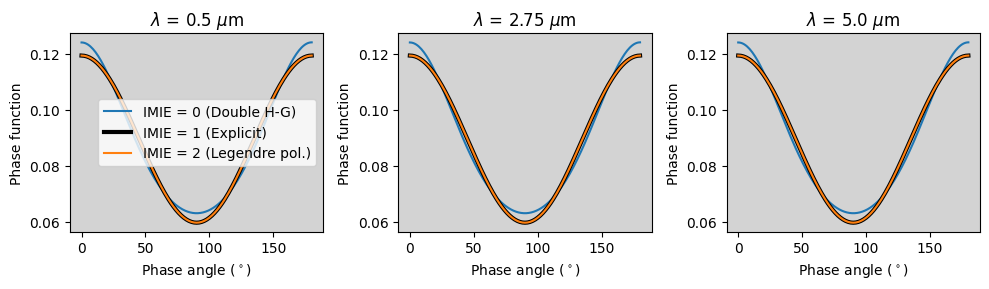

In [20]:
#Calculating the phase function with IMIE = 1 (explicit)
######################################################################################

Scatter.IMIE = 1

#Initialising arrays again
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Calling Makephase
idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

phase_explicit = Scatter.calc_phase(Scatter.THETA,Scatter.WAVE)


#Calculating the phase function with IMIE = 2 (Legendre polynomials)
######################################################################################

Scatter.IMIE = 2

NLPOL = 100   #100 Legendre polynomials

#Initialising arrays again
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA,NLPOL)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Calling Makephase
idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

phase_lp = Scatter.calc_phase(Scatter.THETA,Scatter.WAVE)


#Making summary plot
########################################################################################

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,3))

iwave = 0
ax1.plot(Scatter.THETA,phase_hg[iwave,:,idust],label='IMIE = 0 (Double H-G)')
ax1.plot(Scatter.THETA,phase_explicit[iwave,:,idust],label='IMIE = 1 (Explicit)',c='black',linewidth=3.)
ax1.plot(Scatter.THETA,phase_lp[iwave,:,idust],label='IMIE = 2 (Legendre pol.)')
ax1.set_title('$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
ax1.set_facecolor('lightgray')

iwave = int(Scatter.NWAVE/2)
ax2.plot(Scatter.THETA,phase_hg[iwave,:,idust],label='IMIE = 0')
ax2.plot(Scatter.THETA,phase_explicit[iwave,:,idust],label='IMIE = 1',c='black',linewidth=3.)
ax2.plot(Scatter.THETA,phase_lp[iwave,:,idust],label='IMIE = 2')
ax2.set_title('$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
ax2.set_facecolor('lightgray')

iwave = Scatter.NWAVE - 1
ax3.plot(Scatter.THETA,phase_hg[iwave,:,idust],label='IMIE = 0')
ax3.plot(Scatter.THETA,phase_explicit[iwave,:,idust],label='IMIE = 1',c='black',linewidth=3.)
ax3.plot(Scatter.THETA,phase_lp[iwave,:,idust],label='IMIE = 2')
ax3.set_title('$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
ax3.set_facecolor('lightgray')

ax1.legend()

ax1.set_xlabel('Phase angle ($^\circ$)')
ax2.set_xlabel('Phase angle ($^\circ$)')
ax3.set_xlabel('Phase angle ($^\circ$)')

ax1.set_ylabel('Phase function')
ax2.set_ylabel('Phase function')
ax3.set_ylabel('Phase function')

plt.tight_layout()


## 9. Writing the output files

Once we have calculated our optical properties of the aerosols, we may want to write the outputs into files using the format of the input files required by archNEMESIS and NEMESIS.

### Writing the output into standard archNEMESIS HDF5 file

We are going to run *Makephase* for one of the previous cases and write the calculated optical properties into the HDF5 required by archNEMESIS to run forward models and retrievals.

Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.0000450198632251
Maximum integral of phase function is  1.0001966612381192
Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.000011255322207
Maximum integral of phase function is  1.0000491675803809


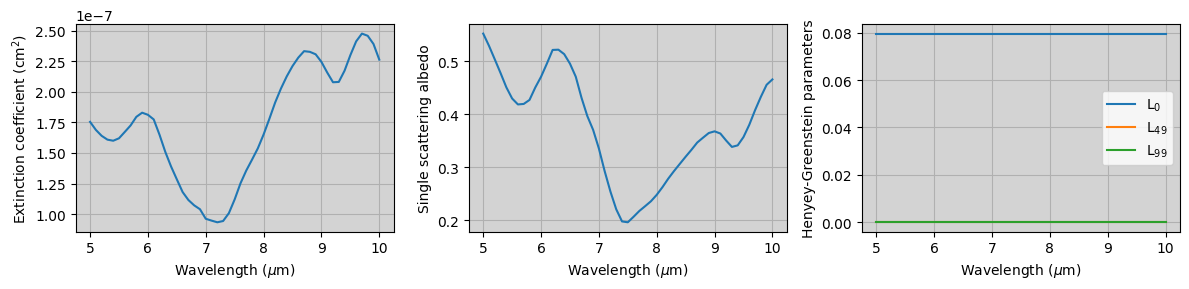

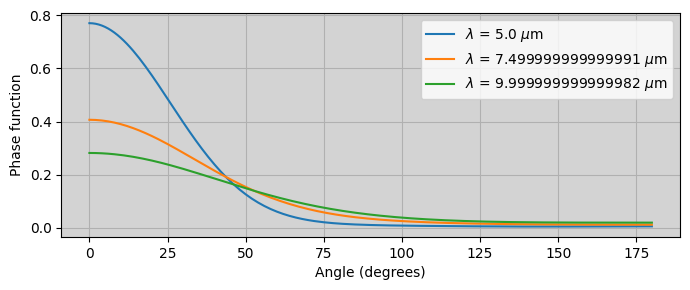

In [3]:
#Defining the general inputs for our class
###############################################################################################

#Initialising the scatter class
Scatter = ans.Scatter_0()

#Defining the characteristics of the class
Scatter.ISPACE = 1   #Units of the calculations (0 - Wavenumber in cm-1 ; 1 - Wavelength in um)
Scatter.IMIE = 2     #Phase function defined using a combination of Legendre polynomials

NDUST = 1      #Number of aerosol populations that we want to include in our atmosphere
NLPOL = 100    #Number of Legendre polynomials to describe the phase function

wavel = np.arange(5.,10.+0.1,0.1)
NWAVE = len(wavel)    #Number of spectral points

NTHETA = 181   #Number of angles for defining the phase function (from 0 to 180)
theta = np.linspace(0.,180.,NTHETA) #Number of phase angles

#Now we initialise the arrays that will be filled with the calculations
Scatter.initialise_arrays(NDUST,NWAVE,NTHETA,NLPOL=NLPOL)
Scatter.WAVE = wavel
Scatter.THETA = theta

#Defining the inputs for our calculations of this particle aerosol distribution
################################################################################################

#Reading the refractive index from the dictionary (Mars mineral dust)
Scatter.read_refind(4)

#Defining the inputs for our standard gamma particle size distribution
iscat = 3  #Modified gamma distribution
a = 2. ; b = 8.e-3 ; c = 6. 
pars = np.array([a,b,c]) 

idust = 0    #The index of the aerosol populations in the class that this calculation corresponds to (from 0 to NDUST-1)
Scatter.makephase(idust,iscat,pars)

#Making a summary plot
#################################################################################################

#Plotting the extinction coefficient and single scattering albedo and the double HG parameters
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))

ax1.plot(Scatter.WAVE,Scatter.KEXT[:,idust])
ax1.grid()
ax1.set_ylabel('Extinction coefficient (cm$^2$)')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_facecolor('lightgray')

ax2.plot(Scatter.WAVE,Scatter.SGLALB[:,idust])
ax2.grid()
ax2.set_ylabel('Single scattering albedo')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_facecolor('lightgray')


ax3.plot(Scatter.WAVE,Scatter.WLPOL[:,0,idust],label='L$_{0}$')
ax3.plot(Scatter.WAVE,Scatter.WLPOL[:,49,idust],label='L$_{49}$')
ax3.plot(Scatter.WAVE,Scatter.WLPOL[:,99,idust],label='L$_{99}$')
ax3.grid()
ax3.legend()
ax3.set_ylabel('Henyey-Greenstein parameters')
ax3.set_xlabel('Wavelength ($\mu$m)')
ax3.set_facecolor('lightgray')

plt.tight_layout()

#Calculating the actual phase function from our double HG parameterisation
##################################################################################################

theta = np.linspace(0.,180.,181)
phase = Scatter.calc_phase(theta,Scatter.WAVE)

#Plotting the phase function for three wavelengths
fig,(ax1) = plt.subplots(1,1,figsize=(7,3))

iwave = 0
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = int(Scatter.NWAVE/2)
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')
iwave = Scatter.NWAVE - 1
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(Scatter.WAVE[iwave])+' $\mu$m')

ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Phase function')
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.legend()
plt.tight_layout()

Scatter.check_phase_norm()


Normalisation of phase function should be 1.0
Minimum integral of phase function is  1.000011255322207
Maximum integral of phase function is  1.0000491675803809


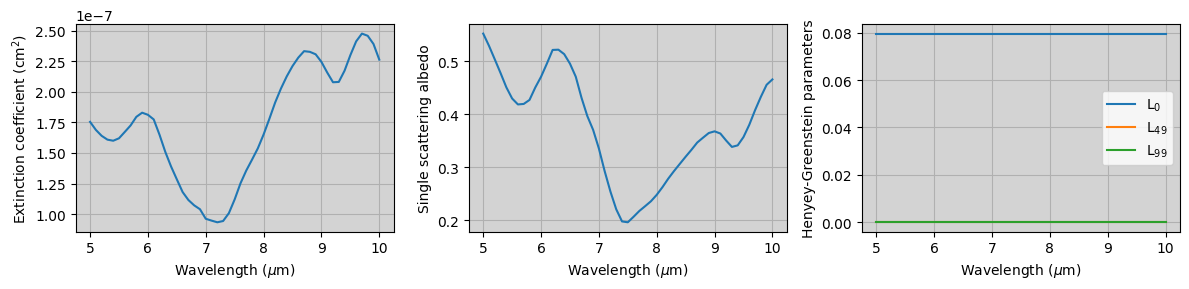

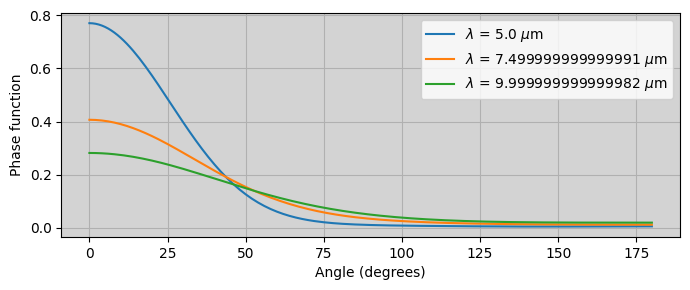

In [4]:
#Writing the properties into HDF5 file
#################################################################################################
Scatter.write_hdf5('example')

#Reading the HDF5 file with another class and checking that the information is correctly stored
#################################################################################################
ScatterX = ans.Scatter_0()
ScatterX.read_hdf5('example')

#Making a summary plot
#################################################################################################

#Plotting the extinction coefficient and single scattering albedo and the double HG parameters
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))

ax1.plot(ScatterX.WAVE,ScatterX.KEXT[:,idust])
ax1.grid()
ax1.set_ylabel('Extinction coefficient (cm$^2$)')
ax1.set_xlabel('Wavelength ($\mu$m)')
ax1.set_facecolor('lightgray')

ax2.plot(ScatterX.WAVE,ScatterX.SGLALB[:,idust])
ax2.grid()
ax2.set_ylabel('Single scattering albedo')
ax2.set_xlabel('Wavelength ($\mu$m)')
ax2.set_facecolor('lightgray')

ax3.plot(ScatterX.WAVE,ScatterX.WLPOL[:,0,idust],label='L$_{0}$')
ax3.plot(ScatterX.WAVE,ScatterX.WLPOL[:,49,idust],label='L$_{49}$')
ax3.plot(ScatterX.WAVE,ScatterX.WLPOL[:,99,idust],label='L$_{99}$')
ax3.grid()
ax3.legend()
ax3.set_ylabel('Henyey-Greenstein parameters')
ax3.set_xlabel('Wavelength ($\mu$m)')
ax3.set_facecolor('lightgray')

plt.tight_layout()

#Calculating the actual phase function from our double HG parameterisation
##################################################################################################

theta = np.linspace(0.,180.,181)
phase = ScatterX.calc_phase(theta,ScatterX.WAVE)

#Plotting the phase function for three wavelengths
fig,(ax1) = plt.subplots(1,1,figsize=(7,3))

iwave = 0
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(ScatterX.WAVE[iwave])+' $\mu$m')
iwave = int(Scatter.NWAVE/2)
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(ScatterX.WAVE[iwave])+' $\mu$m')
iwave = Scatter.NWAVE - 1
ax1.plot(theta,phase[iwave,:,idust],label='$\lambda$ = '+str(ScatterX.WAVE[iwave])+' $\mu$m')

ax1.set_xlabel('Angle (degrees)')
ax1.set_ylabel('Phase function')
ax1.set_facecolor('lightgray')
ax1.grid()
ax1.legend()
plt.tight_layout()

ScatterX.check_phase_norm()
